# Predicting a customer's next purchase using automated feature engineering

<p style="margin:30px">
    <img width=50% src="https://www.featuretools.com/wp-content/uploads/2017/12/FeatureLabs-Logo-Tangerine-800.png" alt="Featuretools" />
</p>

**As customers use your product, they leave behind a trail of behaviors that indicate how they will act in the future. Through automated feature engineering we can identify the predictive patterns in granular customer behavioral data that can be used to improve the customer's experience and generate additional revenue for your business.**

In this tutorial, we show how [Featuretools](http://www.featuretools.com) can be used to perform feature engineering on a multi-table dataset of 3 million online grocery orders provided by Instacart to train an accurate machine learning model to predict what product a customer buys next.

*Note: If you are running this notebook yourself, refer to the [read me on Github](https://github.com/featuretools/predict_next_purchase#running-the-tutorial) for instructions to download the Instacart dataset*

## Highlights

* We automatically generate 150+ features using Deep Feature Synthesis and select the 20 most important features for predictive modeling
* We build a pipeline that it can be reused for numerous prediction problems (you can try this yourself!)
* We quickly develop a model on a subset of the data and validate on the entire dataset in a scalable manner using [Dask](http://dask.pydata.org/en/latest/).

In [1]:
import composeml as cp
import featuretools as ft
from dask import bag
from dask.diagnostics import ProgressBar
import pandas as pd
import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import os
ft.__version__

'0.11.0'

## Step 1. Load data

We start by loading in just one partion of our datast. In this case, a partition of our dataset contains the complete purchase history for each user within it. At the end of the tutorial, we will run the pipeline on every partiton to generate a final model. To learn more about loading data into Featuretools, read the guide [here](https://docs.featuretools.com/en/stable/loading_data/using_entitysets.html).

In [2]:
es = utils.load_entityset("partitioned_data/part_1/")
es

Entityset: instacart
  Entities:
    order_products [Rows: 156605, Columns: 7]
    orders [Rows: 16328, Columns: 3]
    users [Rows: 1000, Columns: 2]
  Relationships:
    order_products.order_id -> orders.order_id
    orders.user_id -> users.user_id

## Visualize EntitySet

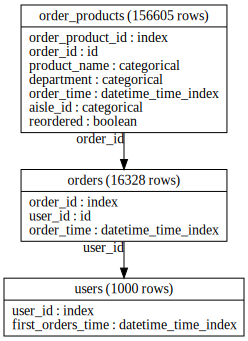

In [3]:
es.plot()

## Step 2. Make Labels

For supervised machine learning, we need labels. These labels define what our predictive model will be used for. In this tutorial, we will predict if a customer will buy Bananas in the next 4 weeks. To structure the labeling process, we will use [Compose](https://github.com/FeatureLabs/compose) which is an open source project for automatically generating labels with cutoff times.

To get started, we define the labeling function that will return whether a customer bought a product given purchases within a time frame.

In [4]:
def bought_product(df, product_name):
    purchased = df.product_name.str.contains(product_name).any()
    return purchased

With the labeling function, we create and configure the label maker for our specific prediction problem. To process 4 weeks of purchases for each customer, we set the `target_entity` to the customer ID and the `window_size` to 4 weeks.

In [5]:
lm = cp.LabelMaker(
    target_entity='user_id',
    time_index='order_time',
    labeling_function=bought_product,
    window_size='4w',
)

This helper function will create a single table from the entity set which is needed for generating label times.

In [6]:
def denormalize(es):
    df = es['order_products'].df.merge(es['orders'].df).merge(es['users'].df)
    return df

df = denormalize(es)

Next, the label maker will continuously search until there is no data to label whether a customer bought bananas given 4 weeks of purchases. This happens when we use `search` with no limit for `num_examples_per_instance` and when we set the `product_name` to bananas. Also, the first cutoff time is set to `2015-03-05` by using the `minimum_data` parameter.

If you are running this code yourself, feel free to experiment with any of these parameters! For example, try to predict if a customer will buy "Limes" instead of "Bananas" or increase your `window_size`.

In [7]:
label_times = lm.search(
    df.sort_values('order_time'),
    minimum_data='2015-03-15',
    num_examples_per_instance=-1,
    product_name='Banana',
    verbose=True,
)

label_times.head()

Elapsed: 00:04 | Remaining: 00:00 | Progress: 100%|██████████| user_id: 1000/1000 


,user_id,cutoff_time,bought_product
id,,,
0,1001,2015-03-15,False
1,1001,2015-04-12,False
2,1002,2015-03-15,False
3,1002,2015-04-12,False
4,1002,2015-05-10,False


We can see above the our training examples contain three pieces of information: a user id, the last time we can use data before feature engineering (called the "cutoff time"), and the label to predict. These are called our "label times".

We can use `describe` to print out the distribution with the settings and transforms that were used to make these labels. This is useful as a reference for understanding how the labels were generated from raw data. Also, the label distribution is helpful for determining if we have imbalanced labels.

In [8]:
label_times.describe()

Label Distribution
------------------
False     2458
True      1608
Total:    4066


Settings
--------
gap                                            None
label_type                                 discrete
labeling_function                    bought_product
minimum_data                             2015-03-15
num_examples_per_instance                        -1
target_entity                               user_id
window_size                  <4 * Weeks: weekday=6>


Transforms
----------
No transforms applied



## 3. Automated Feature Engineering
With our label times in hand, we can use Deep Feature Synthesis to automatically generate features.

When we use DFS, we specify

* `target_entity` - the table to build feature for
* `cutoff_time` the point in time to calculate the features
* `training_window` - the amount of historical data we want to use when calculating features

A good way to think of the `cutoff_time` is that it let's us "pretend" we are at an earlier point in time when generating our features so we can simulate making predictions. We get this time for each customer from the label times we generated above.

In [9]:
feature_matrix, features = ft.dfs(target_entity="users", 
                                  cutoff_time=label_times,
                                  training_window=ft.Timedelta("60 days"), # same as above
                                  entityset=es,
                                  verbose=True)
# encode categorical values
fm_encoded, features_encoded = ft.encode_features(feature_matrix,
                                                  features)

print("Number of features %s" % len(features_encoded))
fm_encoded.head(10)

Built 78 features
Elapsed: 00:39 | Progress: 100%|██████████
Number of features 181


,COUNT(orders),COUNT(order_products),PERCENT_TRUE(order_products.reordered),NUM_UNIQUE(order_products.aisle_id),NUM_UNIQUE(order_products.department),NUM_UNIQUE(order_products.product_name),MODE(order_products.aisle_id) = 24,MODE(order_products.aisle_id) = 83,MODE(order_products.aisle_id) = 120,MODE(order_products.aisle_id) = 32,...,MODE(order_products.orders.user_id) = 1420,MODE(order_products.orders.user_id) = 1164,MODE(order_products.orders.user_id) = 1990,MODE(order_products.orders.user_id) = 1983,MODE(order_products.orders.user_id) = 1967,MODE(order_products.orders.user_id) = 1943,MODE(order_products.orders.user_id) = 1850,MODE(order_products.orders.user_id) = 1819,MODE(order_products.orders.user_id) is unknown,bought_product
user_id,,,,,,,,,,,,,,,,,,,,,
1001,2,33,0.424242,20,11,26,0,0,0,0,...,0,0,0,0,0,0,0,0,1,False
1001,2,33,0.606061,20,12,25,0,0,0,0,...,0,0,0,0,0,0,0,0,1,False
1002,5,49,0.244898,16,8,40,0,0,0,0,...,0,0,0,0,0,0,0,0,1,False
1002,7,52,0.307692,17,8,44,0,0,0,0,...,0,0,0,0,0,0,0,0,1,False
1002,6,27,0.259259,13,6,25,0,0,0,0,...,0,0,0,0,0,0,0,0,1,False
1002,4,25,0.240000,14,6,23,0,0,0,0,...,0,0,0,0,0,0,0,0,1,False
1002,2,9,0.555556,6,5,9,0,0,0,0,...,0,0,0,0,0,0,0,0,1,False
1002,2,9,0.555556,5,4,8,0,0,0,0,...,0,0,0,0,0,0,0,0,1,False
1002,3,8,0.500000,6,4,7,0,0,0,0,...,0,0,0,0,0,0,0,0,1,True


## Step 4. Machine Learning

Using the default parameters, we generated 160 potential features for our prediction problem. With a few simple commands, this feature matrix can be used for machine learning

In [10]:
X = utils.merge_features_labels(fm_encoded, label_times)
X.drop(["user_id", "cutoff_time"], axis=1, inplace=True)
X = X.fillna(0)
y = X.pop("bought_product").astype('bool')

Let's train a Random Forest and validate using 3-fold cross validation

In [11]:
clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)
scores = cross_val_score(estimator=clf,X=X, y=y, cv=3,
                         scoring="roc_auc", verbose=True)

"AUC %.2f +/- %.2f" % (scores.mean(), scores.std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.3s finished


'AUC 0.91 +/- 0.01'

We can see we perform noticably better than guessing! However, we have a pretty high difference in performance accross folds.

To improve this, let's identify the top 20 features using a Random Forest and then perform machine learning on the whole dataset (all of the partions).

In [12]:
clf.fit(X, y)
top_features = utils.feature_importances(clf, features_encoded, n=20)

1: Feature: COUNT(order_products WHERE product_name = Bag of Organic Bananas), 0.090
2: Feature: COUNT(order_products WHERE product_name = Banana), 0.080
3: Feature: COUNT(order_products WHERE department = produce), 0.034
4: Feature: COUNT(order_products WHERE department = dairy eggs), 0.026
5: Feature: MODE(orders.MODE(order_products.product_name)) is unknown, 0.026
6: Feature: SUM(orders.NUM_UNIQUE(order_products.product_name)), 0.022
7: Feature: MAX(orders.NUM_UNIQUE(order_products.product_name)), 0.021
8: Feature: MODE(order_products.product_name) is unknown, 0.020
9: Feature: MEAN(orders.COUNT(order_products)), 0.020
10: Feature: MAX(orders.COUNT(order_products)), 0.020
11: Feature: MEAN(orders.NUM_UNIQUE(order_products.product_name)), 0.019
12: Feature: COUNT(order_products), 0.019
13: Feature: MODE(orders.MODE(order_products.aisle_id)) = 24, 0.019
14: Feature: MODE(order_products.aisle_id) = 24, 0.018
15: Feature: NUM_UNIQUE(order_products.product_name), 0.018
16: Feature: MODE(

To persist this features, we can save them to disk.

In [13]:
ft.save_features(top_features, "top_features")

### Understanding feature engineering in Featuretools

Before moving forward, take a look at the feature we created. You will see that they are more than just simple transformations of columns in our raw data. Instead, they aggregations (and sometimes stacking of aggregations) across the relationships in our dataset. If you're curious how this works, learn about the Deep Feature Synthesis algorithm in our documentation [here](https://docs.featuretools.com/en/stable/automated_feature_engineering/afe.html).

DFS is so powerful because with no manual work, the library figured out that historical purchases of bananas are important for predicting future purchases. Additionally, it surfaces that purchasing dairy or eggs and reordering behavior are important features. 

Even though these features are intuitive, Deep Feature Synthesis will automatically adapt as we change the prediction problem, saving us the time of manually brainstorming and implementing these data transformation. 

## Scaling to full dataset

Once we have written the pipeline for one partition, we can easily scale it out to the full dataset using [Dask](https://dask.pydata.org). A similar pipeline could also be built using [Spark](https://spark.apache.org/docs/2.2.0/api/python/).

In [14]:
pbar = ProgressBar()
pbar.register()

First, we assemble our partitions and map them to entity sets using the function from before. A single partition contains all the data for each user within it, so this computation is easily parallelized. 

In [15]:
path = "partitioned_data/"
#_, dirnames, _ = os.walk(path).next()
dirnames = [os.path.join(path, d) for d in os.listdir(path)]
b = bag.from_sequence(dirnames)
entity_sets = b.map(utils.load_entityset)

Next, we create label times for each entity set

In [16]:
def add_label_times(es):
    df = denormalize(es)
    lt = lm.search(
        df.sort_values('order_time'),
        minimum_data='2015-03-01',
        num_examples_per_instance=-1,
        product_name='Banana',
        verbose=False,
    )
    return lt, es

label_times = entity_sets.map(add_label_times)
label_times

dask.bag<add_lab..., npartitions=104>

In [17]:
# load in the features from before
top_features = ft.load_features("top_features")
feature_matrices = label_times.map(utils.calculate_feature_matrix, features=top_features)

The compute method can take an argument `num_workers` which defaults to using all of the cores on your computer. If you don't want it to do that, you can explicitly specify a number of workers with `feature_matrices.compute(num_workers=2)` where you can replace 2 with the number of cores you want to use.

In [18]:
fms_out = feature_matrices.compute()
X = pd.concat(fms_out)

[########################################] | 100% Completed | 42min 58.3s


Now, we repeat the same machine learning steps from the sample dataset

In [19]:
X.drop(["user_id", "cutoff_time", "time"], axis=1, inplace=True)
X = X.fillna(0)
y = X.pop("bought_product").astype('bool')

In [20]:
clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)
scores = cross_val_score(estimator=clf,X=X, y=y, cv=3, error_score='raises',
                         scoring="roc_auc", verbose=True)

"AUC %.2f +/- %.2f" % (scores.mean(), scores.std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/jeff.hernandez/miniconda/envs/notebook/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/jeff.hernandez/miniconda/envs/notebook/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 26.6min finished


'AUC 0.91 +/- 0.00'

We can now we that our accuracy has stabalized across folds, giving us much more confidence in our model.

Now, let's look at the top features

In [21]:
clf.fit(X, y)
top_features = utils.feature_importances(clf, top_features, n=20)

1: Feature: COUNT(order_products WHERE product_name = Banana), 0.168
2: Feature: COUNT(order_products WHERE product_name = Bag of Organic Bananas), 0.130
3: Feature: COUNT(order_products WHERE department = produce), 0.077
4: Feature: MODE(orders.MODE(order_products.product_name)) is unknown, 0.064
5: Feature: SUM(orders.PERCENT_TRUE(order_products.reordered)), 0.048
6: Feature: MEAN(orders.COUNT(order_products)), 0.047
7: Feature: MEAN(orders.NUM_UNIQUE(order_products.product_name)), 0.047
8: Feature: MEAN(orders.NUM_UNIQUE(order_products.aisle_id)), 0.046
9: Feature: COUNT(order_products WHERE department = dairy eggs), 0.045
10: Feature: NUM_UNIQUE(order_products.product_name), 0.042
11: Feature: SUM(orders.NUM_UNIQUE(order_products.aisle_id)), 0.038
12: Feature: COUNT(order_products), 0.037
13: Feature: SUM(orders.NUM_UNIQUE(order_products.product_name)), 0.036
14: Feature: MAX(orders.COUNT(order_products)), 0.036
15: Feature: MAX(orders.NUM_UNIQUE(order_products.product_name)), 0.03

We can see the top features shifted around a bit, but mostly stayed the same.

## Next Steps

While this is an end-to-end example of going from raw data to a trained machine learning model, it is necessary to do further exploration before claiming we've built something impact full.

Fortunately, Featuretools makes it easy to build structured data science pipeline. As a next steps, you could
* Further validate these results by creating feature vectors at different cutoff times
* Define other prediction problems for this dataset (you can even change the entity you are making predictions on!)
* Save feature matrices to disk as CSVs so they can be reused with different problems without recalculating
* Experiment with parameters to Deep Feature Synthesis
* Create custom primitives for DFS. More info [here](https://docs.featuretools.com/en/stable/automated_feature_engineering/primitives.html).

<p>
    <img src="https://www.featurelabs.com/wp-content/uploads/2017/12/logo.png" alt="Featuretools" />
</p>


Featuretools was created by the developers at [Feature Labs](https://www.featurelabs.com/). If building impactful data science pipelines is important to you or your business, please [get in touch](https://www.featurelabs.com/contact).